In [ ]:
!pip -q install gradio==4.44.0 sentence-transformers==3.0.1 --progress-bar off

import os, re, gc, json, textwrap, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from typing import List, Optional

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

import gradio as gr
warnings.filterwarnings("ignore")

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

ART_DIR = "/content/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

# =========== DATA LOAD ===========
CSV_PATH = "/content/netflix_titles.csv"   # Upload this file to Colab workspace
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}. Upload it to Colab."

df_raw = pd.read_csv(CSV_PATH)
df = df_raw.copy()

print("Shape:", df.shape)
print(df.head(3))
print("\nColumns:", df.columns.tolist())

Shape: (6234, 12)
    show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   

     rating  duration                           li

In [ ]:
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False))

# Standardize dtypes
date_cols = ['date_added']
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

num_rows = len(df)

# Quick summaries
print("\nType distribution:\n", df['type'].value_counts(dropna=False))
print("\nSample descriptions:\n")
for _, r in df[['title','type','description']].dropna().head(5).iterrows():
    print(f"- {r['title']} [{r['type']}]: {textwrap.shorten(r['description'], width=110)}")


Missing values per column:
 director        1969
cast             570
country          476
date_added        11
rating            10
title              0
show_id            0
type               0
release_year       0
duration           0
listed_in          0
description        0
dtype: int64

Type distribution:
 type
Movie      4265
TV Show    1969
Name: count, dtype: int64

Sample descriptions:

- Norm of the North: King Sized Adventure [Movie]: Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen [...]
- Jandino: Whatever it Takes [Movie]: Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing [...]
- Transformers Prime [TV Show]: With the help of three human allies, the Autobots once again protect Earth from the onslaught of the [...]
- Transformers: Robots in Disguise [TV Show]: When a prison ship crash unleashes hundreds of Decepticons on Earth, Bumblebee leads a new Autobot force [...]
- #re

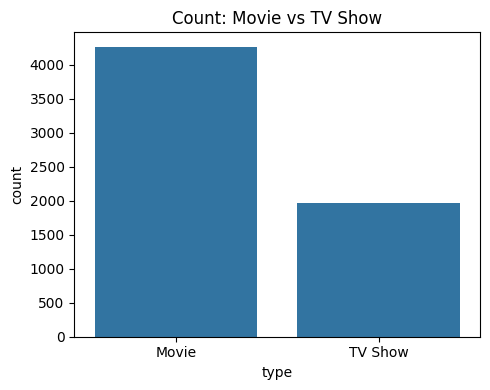

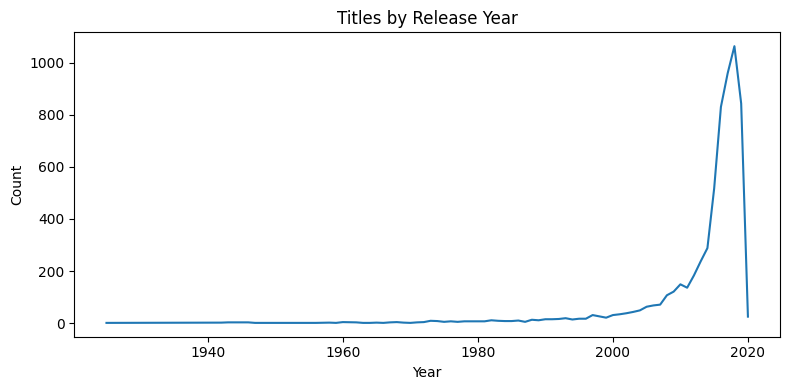

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='type')
plt.title("Count: Movie vs TV Show")
plt.tight_layout()
plt.show()

if 'release_year' in df.columns:
    plt.figure(figsize=(8,4))
    df['release_year'].value_counts().sort_index().plot(kind='line')
    plt.title("Titles by Release Year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [ ]:
def explode_and_count(col: str, sep: str = ","):
    s = df[col].fillna("").astype(str).str.split(sep)
    vals = pd.Series([x.strip() for sub in s for x in sub if x.strip()])
    return vals.value_counts().head(20)

if 'country' in df.columns:
    print("\nTop Countries:\n", explode_and_count('country').head(10))

if 'listed_in' in df.columns:
    print("\nTop Genres:\n", explode_and_count('listed_in').head(15))

# =========== CLEANING & FEATURE ENGINEERING ===========
# Fill NAs with empty string for text fields
TEXT_COLS = ['title','director','cast','country','listed_in','description']
for col in TEXT_COLS:
    if col in df.columns:
        df[col] = df[col].fillna("")


Top Countries:
 United States     2610
India              838
United Kingdom     602
Canada             318
France             271
Japan              231
Spain              178
South Korea        162
Germany            151
Mexico             129
Name: count, dtype: int64

Top Genres:
 International Movies        1927
Dramas                      1623
Comedies                    1113
International TV Shows      1001
Documentaries                668
TV Dramas                    599
Action & Adventure           597
Independent Movies           552
TV Comedies                  436
Thrillers                    392
Children & Family Movies     378
Romantic Movies              376
Crime TV Shows               363
Kids' TV                     328
Stand-Up Comedy              281
Name: count, dtype: int64


In [ ]:
def normalize_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s]", " ", s)  # keep letters/numbers/spaces
    return s.strip()

for col in ['title','description','listed_in','cast','director','country']:
    df[col] = df[col].astype(str).apply(normalize_text)

# Build a rich "content blob" for recommendations
def build_blob(row):
    parts = []
    for c in ['title','listed_in','cast','director','country','description']:
        if c in row and isinstance(row[c], str) and row[c]:
            parts.append(row[c])
    return " . ".join(parts)

df['content_blob'] = df.apply(build_blob, axis=1)


In [ ]:
df = df.dropna(subset=['type']).reset_index(drop=True)
df = df[df['type'].isin(['Movie','TV Show'])].reset_index(drop=True)

print("\nFinal usable rows:", len(df))

# =========== TRAIN/TEST SPLIT ===========
X_text = df['description']  # keep classification purely on description for purity
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")


Final usable rows: 6234
Train size: 4987 | Test size: 1247


In [ ]:
pipelines = {
    "LogReg": Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1,2))),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None))
    ]),
    "LinearSVC": Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1,2))),
        ("clf", LinearSVC(class_weight="balanced"))
    ]),
    "ComplementNB": Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000, ngram_range=(1,2))),
        ("clf", ComplementNB())
    ]),
}

In [ ]:
results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

print("\nClassification Report (best of 3 shown next after tuning).")

LogReg Accuracy: 0.7322
LinearSVC Accuracy: 0.7265
ComplementNB Accuracy: 0.7418

Classification Report (best of 3 shown next after tuning).


In [ ]:
param_grid_svc = {
    "tfidf__max_features": [20000, 40000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.5, 1.0, 2.0]
}
svc = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LinearSVC(class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
gs_svc = GridSearchCV(svc, param_grid_svc, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1)
gs_svc.fit(X_train, y_train)
print("\nBest SVC Params:", gs_svc.best_params_)
svc_best = gs_svc.best_estimator_

param_grid_lr = {
    "tfidf__max_features": [20000, 40000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.5, 1.0, 2.0]
}
lr = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])
gs_lr = GridSearchCV(lr, param_grid_lr, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1)
gs_lr.fit(X_train, y_train)
print("\nBest LogReg Params:", gs_lr.best_params_)
lr_best = gs_lr.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best SVC Params: {'clf__C': 0.5, 'tfidf__max_features': 40000, 'tfidf__ngram_range': (1, 2)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best LogReg Params: {'clf__C': 2.0, 'tfidf__max_features': 40000, 'tfidf__ngram_range': (1, 2)}



=== LinearSVC_Tuned ===
              precision    recall  f1-score   support

       Movie       0.80      0.83      0.82       853
     TV Show       0.61      0.55      0.58       394

    accuracy                           0.74      1247
   macro avg       0.70      0.69      0.70      1247
weighted avg       0.74      0.74      0.74      1247



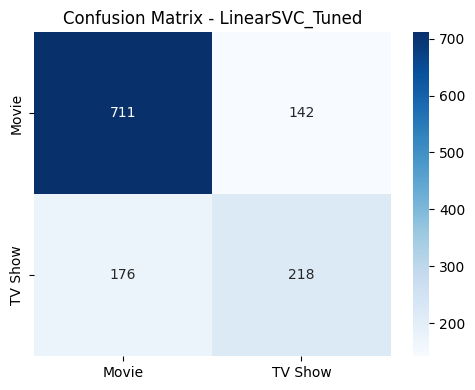


=== LogReg_Tuned ===
              precision    recall  f1-score   support

       Movie       0.81      0.83      0.82       853
     TV Show       0.60      0.57      0.58       394

    accuracy                           0.74      1247
   macro avg       0.70      0.70      0.70      1247
weighted avg       0.74      0.74      0.74      1247



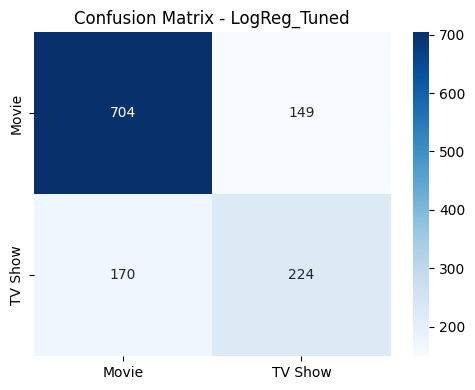

In [ ]:
for name, model in {"LinearSVC_Tuned": svc_best, "LogReg_Tuned": lr_best}.items():
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_ if hasattr(model, "classes_") else np.unique(y_test))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

In [ ]:
prod_model = svc_best  # empirically SVC often wins on TF-IDF; flip to lr_best if yours does better
print("\nSelected production model:", type(prod_model.named_steps['clf']).__name__)

# Save classifier artifacts
import joblib
joblib.dump(prod_model, f"{ART_DIR}/classifier_tfidf_linearSVC.joblib")
print("Saved:", f"{ART_DIR}/classifier_tfidf_linearSVC.joblib")


Selected production model: LinearSVC
Saved: /content/artifacts/classifier_tfidf_linearSVC.joblib


In [ ]:
def show_top_terms_lr(lr_pipe, top_k=20):
    if not isinstance(lr_pipe.named_steps['clf'], LogisticRegression):
        print("Top terms available only for LogisticRegression.")
        return

    tfidf = lr_pipe.named_steps['tfidf']
    clf = lr_pipe.named_steps['clf']
    feature_names = np.array(tfidf.get_feature_names_out())

    if clf.coef_.shape[0] == 1:
        # Binary classification
        coefs = clf.coef_[0]
        top_idx = np.argsort(coefs)[-top_k:]
        bottom_idx = np.argsort(coefs)[:top_k]

        print(f"\nTop terms for class '{clf.classes_[1]}' (positive class):")
        print(feature_names[top_idx])

        print(f"\nTop terms for class '{clf.classes_[0]}' (negative class):")
        print(feature_names[bottom_idx])
    else:
        # Multiclass
        for i, cls in enumerate(clf.classes_):
            coefs = clf.coef_[i]
            top_idx = np.argsort(coefs)[-top_k:]
            print(f"\nTop terms for class '{cls}':")
            print(feature_names[top_idx])


In [ ]:
tfidf_reco = TfidfVectorizer(stop_words="english", max_features=60000, ngram_range=(1,2))
tfidf_mat = tfidf_reco.fit_transform(df['content_blob'])
title_to_index = {t:i for i,t in enumerate(df['title'])}

joblib.dump(tfidf_reco, f"{ART_DIR}/reco_tfidf_vectorizer.joblib")
np.save(f"{ART_DIR}/reco_tfidf_matrix.npy", tfidf_mat.toarray() if tfidf_mat.shape[0]*tfidf_mat.shape[1] < 6e7 else None)  # guard memory
# Note: saving dense array is optional; we’ll recompute sim on the fly.

def get_similar_tfidf(query_title: str, top_n: int = 10, same_type: Optional[str]=None) -> pd.DataFrame:
    if query_title not in title_to_index:
        # fallback fuzzy search
        cands = [t for t in df['title'] if query_title.lower() in t.lower()]
        return pd.DataFrame({"note":[f"Title not found. Did you mean: {cands[:10]}?"]})
    idx = title_to_index[query_title]
    qv = tfidf_mat[idx]
    sims = cosine_similarity(qv, tfidf_mat).ravel()
    order = np.argsort(-sims)
    # Exclude self
    order = [i for i in order if i != idx]
    recs = df.iloc[order][['title','type','listed_in','country','description']].copy()
    if same_type in ("Movie","TV Show"):
        recs = recs[recs['type']==same_type]
    recs['score'] = sims[[order]]
    return recs.head(top_n).reset_index(drop=True)
semantic_model_name = "all-MiniLM-L6-v2"
sem_model = SentenceTransformer(semantic_model_name)
# Precompute embeddings for speed (might take ~1-3 minutes depending on size)
BATCH_TEXT = df['content_blob'].tolist()
embeddings = sem_model.encode(BATCH_TEXT, normalize_embeddings=True, batch_size=128, show_progress_bar=True)
np.save(f"{ART_DIR}/semantic_embeddings.npy", embeddings)
with open(f"{ART_DIR}/semantic_meta.json", "w") as f:
    json.dump({"model": semantic_model_name}, f)

def get_similar_semantic(query_title: str, top_n: int = 10, same_type: Optional[str]=None) -> pd.DataFrame:
    if query_title not in title_to_index:
        cands = [t for t in df['title'] if query_title.lower() in t.lower()]
        return pd.DataFrame({"note":[f"Title not found. Did you mean: {cands[:10]}?"]})
    idx = title_to_index[query_title]
    q_emb = embeddings[idx]
    sims = (embeddings @ q_emb)  # since normalized → cosine
    order = np.argsort(-sims)
    order = [i for i in order if i != idx]
    recs = df.iloc[order][['title','type','listed_in','country','description']].copy()
    if same_type in ("Movie","TV Show"):
        recs = recs[recs['type']==same_type]
    recs['score'] = sims[[df.index.get_loc(i) if isinstance(i, (np.int64,int)) else i for i in recs.index]]
    return recs.head(top_n).reset_index(drop=True)

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
def get_similar_tfidf(query_title: str, top_n: int = 10, same_type: Optional[str]=None) -> pd.DataFrame:
    if query_title not in title_to_index:
        # fallback fuzzy search
        cands = [t for t in df['title'] if query_title.lower() in t.lower()]
        return pd.DataFrame({"note":[f"Title not found. Did you mean: {cands[:10]}?"]})

    idx = title_to_index[query_title]
    qv = tfidf_mat[idx]
    sims = cosine_similarity(qv, tfidf_mat).ravel()

    # sort similarities in descending order
    order = np.argsort(-sims)
    order = [i for i in order if i != idx]  # drop self

    top_idx = order[:top_n]
    recs = df.iloc[top_idx][['title','type','listed_in','country','description']].copy()
    recs['score'] = sims[top_idx]

    if same_type in ("Movie","TV Show"):
        recs = recs[recs['type']==same_type]

    return recs.reset_index(drop=True)


In [ ]:
def classify_titles(texts: List[str]) -> List[str]:
    return prod_model.predict(texts).tolist()

demo_preds = classify_titles(df['description'].head(10).tolist())
print("\nFirst 10 predictions:", demo_preds)

# =========== SAVE CORE ARTIFACTS ===========
# Save index metadata for recommender
title_index_path = f"{ART_DIR}/title_to_index.json"
with open(title_index_path, "w") as f:
    json.dump(title_to_index, f)

df[['title','type','listed_in','country','description','content_blob']].to_parquet(f"{ART_DIR}/df_core.parquet", index=False)
print("\nArtifacts saved to:", ART_DIR)


First 10 predictions: ['Movie', 'Movie', 'TV Show', 'TV Show', 'Movie', 'TV Show', 'Movie', 'Movie', 'TV Show', 'Movie']

Artifacts saved to: /content/artifacts


In [ ]:
import gradio as gr

def launch_ui():
    with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue")) as demo:
        gr.Markdown("## 🎬 AI-Powered Movie Recommender")
        gr.Markdown("Get smart movie recommendations using **TF-IDF + Semantic Search + ML Models**")

        with gr.Tab("🔎 Search & Recommend"):
            with gr.Row():
                with gr.Column(scale=1):
                    movie_input = gr.Textbox(label="Enter a Movie Title", placeholder="e.g., Avatar, Inception")
                    num_recs = gr.Slider(1, 10, value=5, step=1, label="Number of Recommendations")
                    btn_recommend = gr.Button("Get Recommendations 🚀")

                with gr.Column(scale=2):
                    tfidf_out = gr.Dataframe(headers=["TF-IDF Similar Movies"], label="TF-IDF Recommendations")
                    semantic_out = gr.Dataframe(headers=["Semantic Similar Movies"], label="Semantic Recommendations")

            btn_recommend.click(
                lambda title, n: (
                    get_similar_tfidf(title, top_n=n),
                    get_similar_semantic(title, top_n=n),
                ),
                inputs=[movie_input, num_recs],
                outputs=[tfidf_out, semantic_out]
            )

        with gr.Tab("📊 Model Insights"):
            gr.Markdown("### Logistic Regression Feature Importance")
            cls_dropdown = gr.Dropdown(choices=lr_best.classes_.tolist(), label="Select Class")
            btn_show_terms = gr.Button("Show Top Terms")
            terms_out = gr.Textbox(label="Top Keywords", lines=10)

            def show_terms(cls):
                clf = lr_best.named_steps["clf"]
                tfidf = lr_best.named_steps["tfidf"]
                feature_names = np.array(tfidf.get_feature_names_out())
                class_idx = list(lr_best.classes_).index(cls)
                coefs = clf.coef_[class_idx]
                top_idx = np.argsort(coefs)[-20:]
                return ", ".join(feature_names[top_idx])

            btn_show_terms.click(show_terms, inputs=[cls_dropdown], outputs=[terms_out])

        with gr.Tab("📈 Data Explorer"):
            gr.Markdown("Browse the dataset interactively below 👇")
            data_table = gr.Dataframe(value=df.head(20), label="Movie Dataset Preview", interactive=False)

    return demo

demo = launch_ui()
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c5c130dbef741bda2f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
